# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile

from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np
import re
from IPython.display import display

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

# Define a global page list, we will fill that later with dictionaries, containing all needed information
newspaper_pages = []

def openImageZipFile(filename):
    '''
    This function will open a zip file containing images. It returns a list of dictionaries, which will contain the
    file names, as well as PIL Image objects, containing the image data. Non-image files in the zip file will
    be ignored
    
    :param filename: the filename of a Zip File
    :return imagelist: a list of dictionaries, where the key "filename" contains the filename and the
    key "image" contains a PIL image object
    '''
    imagelist = []

    try:
        with zipfile.ZipFile(filename) as myZip:
            for item in myZip.infolist():
                with myZip.open(item) as file:
                    try:
                        image = Image.open(file)
                        image.load()
                        imagelist.append({"filename": item.filename, "image":image})
                        print("Loaded image {} from zipfile {}".format(item.filename, filename))
                    except IOError:
                        print("Ignoring file")
                        continue
    except:
        print("Zipfile {} not found".format(filename))
                        
    return imagelist

def addWordListFromImages(imagelist):
    '''
    This function runs OCR using tesseract on the images in imagelist. Imagelist will be modified, each item will 
    afterwards have a key "words" containing all the words found in the page. We do not need to take care of any word
    order or anything. All words will be lower-cased. The word list will only contain unique words.
    
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process    
    '''
    for item in imagelist:
        text = pytesseract.image_to_string(item["image"].convert("1")).lower()
        all_words = re.compile('\w+').findall(text)
        unique_words = []
        for word in all_words:
            if word not in unique_words:
                unique_words.append(word)
        item["words"] = unique_words
        print("Ran OCR on image {} and found {} unique words".format(item["filename"], len(unique_words)))

In [2]:
def detectFacesInImages(imagelist, scale):
    '''
    This function runs a face detection using OpenCV on the images in imagelist. Imagelist will be modified, each item will 
    afterwards have a key "faces" containing the bounding boxes of the faces detected in that image.
    
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process   
    :param scale: The scale factor to apply for face detection
    '''
    for item in imagelist:
        faces = face_cascade.detectMultiScale(np.array(item["image"].convert("L")), scale)
        item["faces"] = faces
        print("Ran Face Detection on image {} and found {} faces".format(item["filename"], len(faces)))

In [3]:
def extractFaceImages(imagelist, thumb_size):
    '''
    This function extracts previously detected faces from an image. There must be a key "faces" in the dictionary.
    
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process    
    '''
   
    for item in imagelist:
        face_images = []
        for rec in item["faces"]:
            # Extract image
            face_images.append(item["image"].crop((rec[0],rec[1],rec[0]+rec[2],rec[1]+rec[3])))
        # And display
        item["face_images"] = face_images

In [4]:
def createContactSheet(images, size=(100,100), columns=5):
    '''
    This function creates a contact sheet from the given image list, resizing the images to thumbnails, displaying
    the images in given number of columns
    
    :param images: A list of Image object to display
    :param size: A tuple defining maximum size for the thumbnails
    :param columns: Number of columns for the images (rows will be calculated)
    :return contact_sheet_image The newly created contact sheet
    '''
    
    t_width, t_height = size
    # Calculate rows and columns
    columns = 5
    rows = int(len(images) / columns + 1)
    
    # determine size of contact sheet
    c_width = columns * t_width
    c_height = rows * t_height
    
    thumbnails = []
    
    # resize to thumbnails, use copies
    for im in images:
        im_cpy = im.copy()
        im_cpy.thumbnail(size)
        thumbnails.append(im_cpy)

    contact_sheet = Image.new("RGB", (c_width, c_height))
    
    # paste images into contact sheet
    r = 0
    c = 0
    for im in thumbnails:
        # paste at current position
        contact_sheet.paste(im, (c*t_width, r*t_height))
        # update position
        c += 1
        if c >= columns:
            c = 0
            r += 1
            
    return contact_sheet
        

In [5]:
def searchImages(term, imagelist):
    '''
    This function runs a search on imagelist. It will look for the term in each images and display a contact
    sheet with all detected faces (if any).
    
    :param term: The word to search for
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process   
    '''
    
    for item in imagelist:
        if term.lower() in item["words"]:
            print("Results found in file {}".format(item["filename"]))
            if len(item["face_images"]) > 0:
                # display contact sheet
                cs = createContactSheet(item["face_images"])
                display(cs)
            else:
                print("But there were no faces in that file!")

In [40]:
# Load images
newspaper_pages = openImageZipFile("readonly/small_img.zip")


Loaded image a-0.png from zipfile readonly/small_img.zip
Loaded image a-1.png from zipfile readonly/small_img.zip
Loaded image a-2.png from zipfile readonly/small_img.zip
Loaded image a-3.png from zipfile readonly/small_img.zip


In [41]:
# Test OCR
addWordListFromImages(newspaper_pages[0:1])

Ran OCR on image a-0.png and found 509 unique words


In [46]:
print(newspaper_pages[0]['words'])
print('mark' in newspaper_pages[0]['words'])

['ann', 'arbor', 'michigan', 'wednesday', 'november', '5', '2014', 'michigandally', 'com', 'snyder', 'earns', 'second', 'term', 'g', 'o', 'p', 'takes', 'control', 'of', 'u', 's', 'senate', 'midterm', 'election', 'results', 'he', 'te', 'ek', 'ee', 'governor', 'rick', 'r', 'lieutenan', 'governo', 'brian', 'calley', 'secre', 'ate', 'ruth', 'johnson', 'ary', 'a', 'torney', 'general', 'ill', 'schuette', 'cr', 'w', 'state', 'rebeka', 'warren', 'd', 'house', 'representatives', 'jeff', 'irwin', 'cd', 'gary', 'peters', 'debbie', 'dingel', 'probate', 'cour', 'julia', 'owdziej', 'circuit', 'patrick', 'conlin', 'mayor', 'christopher', 'taylor', 'city', 'council', 'sumi', 'kailasapathy', 'chuck', 'warpehoski', 'julie', 'grand', 'graydon', 'kraphol', 'kirk', 'westphal', 'too', 'close', 'to', 'call', 'ss', 'top', 'republican', 'gov', 'celebrates', 'after', 'being', 'reelected', 'at', 'the', 'renaissance', 'center', 'in', 'detroit', 'games', 'coller', 'daily', 'bottom', 'left', 'senator', 'elect', 'el

In [63]:
# Test facedetection
detectFacesInImages(newspaper_pages[0:1], 1.35)

Ran Face Detection on image a-0.png and found 6 faces


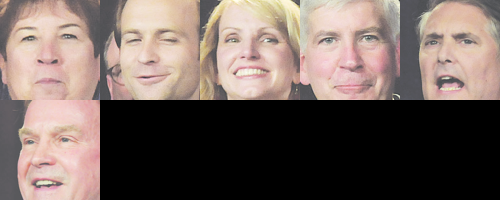

In [69]:
# Extract images
extractFaceImages(newspaper_pages[0:1], (100,100))
cs = createContactSheet(newspaper_pages[0]["face_images"])
display(cs)

In [6]:
# Now run everything on the small images
newspaper_pages_sm = openImageZipFile("small_img.zip")
addWordListFromImages(newspaper_pages_sm)
detectFacesInImages(newspaper_pages_sm, 1.35)

Loaded image a-0.png from zipfile small_img.zip
Loaded image a-1.png from zipfile small_img.zip
Loaded image a-2.png from zipfile small_img.zip
Loaded image a-3.png from zipfile small_img.zip


TesseractNotFoundError: tesseract is not installed or it's not in your path

In [11]:
extractFaceImages(newspaper_pages_sm, (100,100))

Results found in file a-0.png


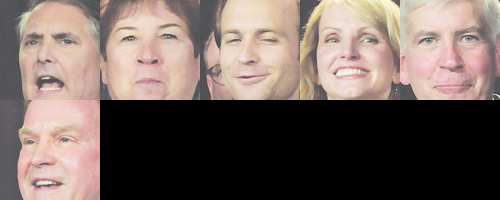

Results found in file a-3.png


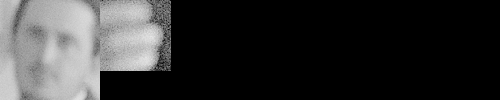

In [14]:
searchImages("Christopher", newspaper_pages_sm)

In [ ]:
# Now run everything on the big images
newspaper_pages = openImageZipFile("readonly/images.zip")
addWordListFromImages(newspaper_pages)
detectFacesInImages(newspaper_pages, 1.35)

Loaded image a-0.png from zipfile readonly/images.zip
Loaded image a-1.png from zipfile readonly/images.zip
Loaded image a-10.png from zipfile readonly/images.zip
Loaded image a-11.png from zipfile readonly/images.zip
Loaded image a-12.png from zipfile readonly/images.zip
Loaded image a-13.png from zipfile readonly/images.zip
Loaded image a-2.png from zipfile readonly/images.zip
Loaded image a-3.png from zipfile readonly/images.zip
Loaded image a-4.png from zipfile readonly/images.zip
Loaded image a-5.png from zipfile readonly/images.zip
Loaded image a-6.png from zipfile readonly/images.zip
Loaded image a-7.png from zipfile readonly/images.zip
Loaded image a-8.png from zipfile readonly/images.zip
Loaded image a-9.png from zipfile readonly/images.zip
Ran OCR on image a-0.png and found 509 unique words


In [ ]:
extractFaceImages(newspaper_pages, (100,100))

In [ ]:
searchImages("Mark", newspaper_pages)